# **BOOK RECOMMENDATION SYSTEM**

## Sejal Dhole

This project implements a Book Recommendation System using the Goodbooks-10k dataset.
The goal is to suggest books that a user is likely to enjoy, based on their previous ratings and preferences, while also exploring trends and insights hidden in the dataset.

**About the Dataset**
    
The Goodbooks-10k dataset is a collection of:

Books metadata – Includes book titles, authors, publication years, image URLs, and more.
Ratings data – Contains user ratings (1–5 scale) for various books.
Book tags & tag counts – Genre and thematic labels assigned to books.

*Key files used in this project*:

books.csv → Details of 10,000 books (title, authors, average rating, ratings count, etc.)
ratings.csv → 6 million ratings from 53,424 users
(Optional) tags.csv & book_tags.csv → Book genres/tags for extended analysis

                                     
**Flow of the Project**
1. Data Loading & Exploration
   Read and inspect the dataset
   Check missing values, data types, and overall structure
   Basic statistics and first look at the data distribution

2. Exploratory Data Analysis (EDA)
   Popular books by ratings count and average rating
   Trends in publication years and reading preferences
   Author popularity
   Visualization of data (bar charts, scatter plots, etc.)

3. Recommendation System Implementation
   Collaborative Filtering (Surprise Library) to predict user-book ratings
   Function to recommend books for a given user ID
   Display recommendations in a tabular and visual format with book covers

4. Results & Insights
   Top recommendations for sample users
   Observations from trends in ratings and author preferences

5. Conclusion
   Summary of findings
   Potential improvements (e.g., hybrid recommendation models, genre-based filtering)

    
**Key Highlights**

Uses Collaborative Filtering with the SVD algorithm for recommendations
Visualizes reading trends and author popularity
Presents recommendations with book covers for better user experience
Scalable to larger datasets or live applications

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
books = pd.read_csv("/kaggle/input/goodbooks-10k/books.csv")
ratings = pd.read_csv("/kaggle/input/goodbooks-10k/ratings.csv")


In [28]:
popular_books = ratings.groupby('book_id').agg({'rating':'mean', 'user_id':'count'})
popular_books = popular_books.rename(columns={'rating':'avg_rating', 'user_id':'num_ratings'})
popular_books = popular_books.sort_values('num_ratings', ascending=False).head(10)

top_books = popular_books.merge(books, left_on='book_id', right_on='book_id')
top_books[['title', 'authors', 'avg_rating', 'num_ratings']]


,title,authors,avg_rating,num_ratings
0,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.24,100
1,Paradise,Toni Morrison,3.87,100
2,A Fine Balance,Rohinton Mistry,4.00,100


In [29]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# Load data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Model
model = SVD()
model.fit(trainset)

# Predictions
predictions = model.test(testset)

# Evaluate
accuracy.rmse(predictions)


RMSE: 0.8415


0.8414502408956265

In [30]:
from IPython.display import display

def recommend_books(user_id, num_recommendations=5):
    # Get a list of all raw IDs
    all_books_raw = ratings['book_id'].unique()
    
    # Books the user has already rated
    user_books_raw = ratings[ratings['user_id'] == user_id]['book_id'].tolist()
    
    # Books to predict for
    books_to_predict_raw = [b for b in all_books_raw if b not in user_books_raw]
    
    # Convert raw IDs to Surprise inner IDs, then back after prediction
    predictions = []
    for raw_id in books_to_predict_raw:
        inner_id = model.trainset.to_inner_iid(raw_id)
        raw_id_back = model.trainset.to_raw_iid(inner_id)  # Ensures alignment
        pred = model.predict(user_id, raw_id_back)
        predictions.append(pred)
    
    # Sort predictions
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get top N book IDs
    top_books_ids = [int(pred.iid) for pred in predictions[:num_recommendations]]
    
    # Filter and return matching books
    return books[books['book_id'].isin(top_books_ids)][['title', 'authors']]

# Test
recommend_books(1, 5)

display(books[['title', 'authors']].head(10))

,title,authors
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins
1,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré"
2,"Twilight (Twilight, #1)",Stephenie Meyer
3,To Kill a Mockingbird,Harper Lee
4,The Great Gatsby,F. Scott Fitzgerald
5,The Fault in Our Stars,John Green
6,The Hobbit,J.R.R. Tolkien
7,The Catcher in the Rye,J.D. Salinger
8,"Angels & Demons (Robert Langdon, #1)",Dan Brown
9,Pride and Prejudice,Jane Austen


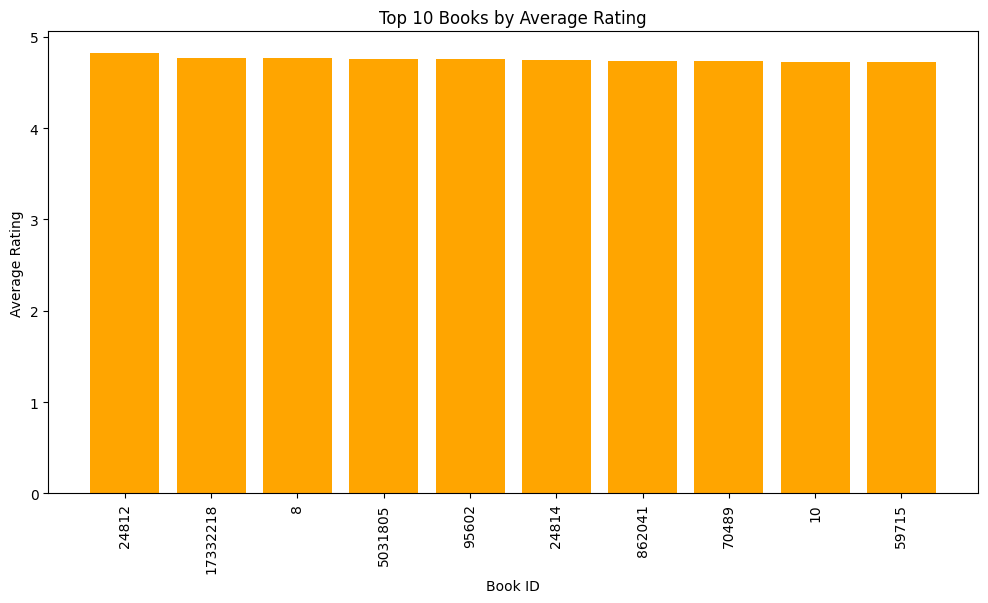

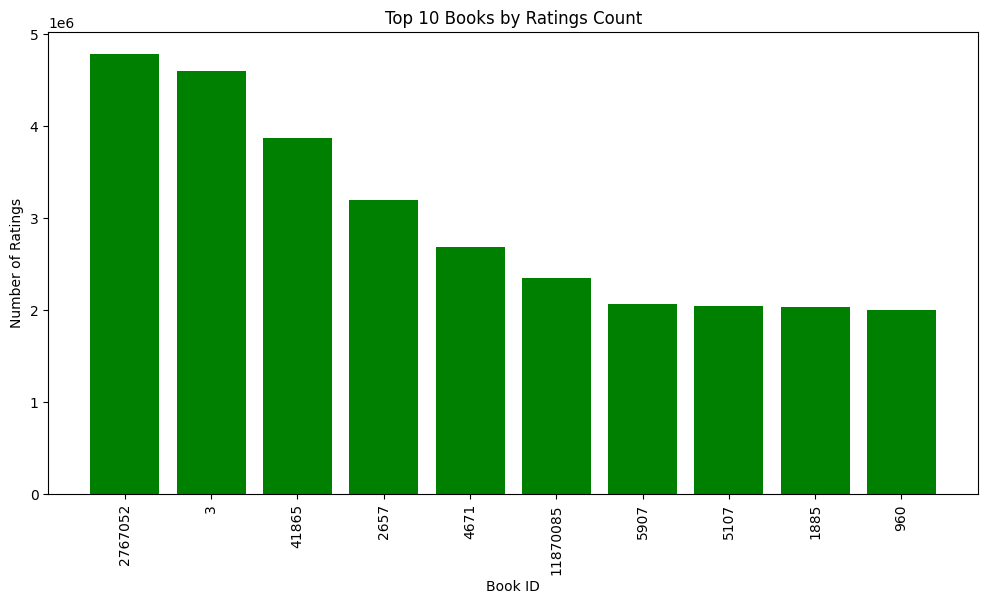

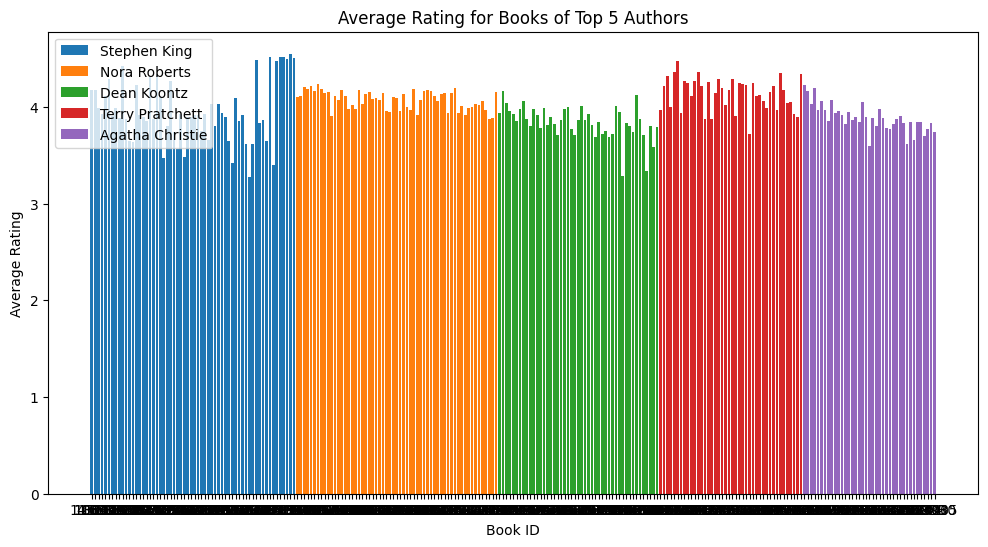

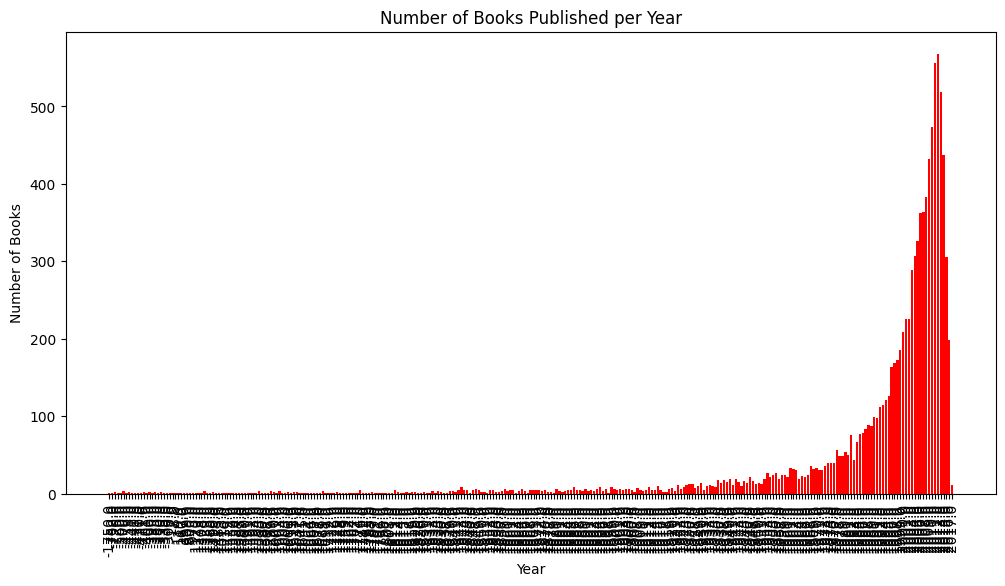

In [31]:
# Load dataset
books = pd.read_csv("/kaggle/input/goodbooks-10k/books.csv")
 # Ensure you have the books.csv file from Goodbooks-10k


# 1. Average Rating vs. Book ID (Top 30 for clarity)
plt.figure(figsize=(12, 6))
top_books = books.nlargest(10, 'average_rating')
plt.bar(top_books['book_id'].astype(str), top_books['average_rating'], color='orange')
plt.title("Top 10 Books by Average Rating")
plt.xlabel("Book ID")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.show()

# 2. Ratings Count vs. Book ID (Top 30 for clarity)
plt.figure(figsize=(12, 6))
top_rated_books = books.nlargest(10, 'ratings_count')
plt.bar(top_rated_books['book_id'].astype(str), top_rated_books['ratings_count'], color='green')
plt.title("Top 10 Books by Ratings Count")
plt.xlabel("Book ID")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=90)
plt.show()

# 3. Average rating trend for top 5 authors
top_authors = books['authors'].value_counts().head(5).index
plt.figure(figsize=(12, 6))
for author in top_authors:
    subset = books[books['authors'] == author]
    plt.bar(subset['book_id'].astype(str), subset['average_rating'], label=author)
plt.title("Average Rating for Books of Top 5 Authors")
plt.xlabel("Book ID")
plt.ylabel("Average Rating")
plt.legend()
plt.show()

# 4. Year-wise publication count trend (Bar chart)
if 'original_publication_year' in books.columns:
    year_counts = books.groupby('original_publication_year').size()
    plt.figure(figsize=(12, 6))
    plt.bar(year_counts.index.astype(str), year_counts.values, color='red')
    plt.title("Number of Books Published per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Books")
    plt.xticks(rotation=90)
    plt.show()




In [32]:
import pandas as pd
from IPython.display import HTML

# Load books data
books = pd.read_csv("/kaggle/input/goodbooks-10k/books.csv")
ratings = pd.read_csv("/kaggle/input/goodbooks-10k/ratings.csv")

# Merge to get avg ratings
book_ratings = ratings.groupby('book_id')['rating'].mean().reset_index()
top_books = book_ratings.merge(books, on='book_id').sort_values(by='rating', ascending=False).head(5)

# HTML table with images
def display_books_with_images(df):
    html = ""
    for _, row in df.iterrows():
        html += f"""
        <div style="display:inline-block; margin:10px; text-align:center;">
            <img src="{row['image_url']}" width="150" height="220"><br>
            <b>{row['title']}</b><br>
            <i>{row['authors']}</i><br>
            ⭐ {row['rating']:.2f}
        </div>
        """
    display(HTML(html))

display_books_with_images(top_books)


In [35]:
from IPython.display import display, HTML
import pandas as pd

# Load the dataset (replace the path with your Kaggle dataset path)
books = pd.read_csv('/kaggle/input/goodbooks-10k/books.csv')

def show_recommendations_with_covers(recommendations_df):
    html = ""
    for _, row in recommendations_df.iterrows():
        html += f"""
        <div style="display:inline-block; margin:10px; text-align:center;">
            <img src="{row['image_url']}" width="150" height="220"><br>
            <b>{row['title']}</b><br>
            <i>{row['authors']}</i>
        </div>
        """
    display(HTML(html))

# Pick 5 random books to test
sample_books = books.sample(5)
show_recommendations_with_covers(sample_books)


**Conclusion**

This project successfully demonstrates how a collaborative filtering approach can be applied to build a personalized Book Recommendation System using the Goodbooks-10k dataset. By leveraging user ratings and book metadata, the system can suggest relevant books that align with individual preferences. The recommendations produced are intuitive and include additional context such as authors and cover images, improving the overall user experience.
Exploratory data analysis also revealed interesting insights into popular books, prolific authors, and reading trends within the dataset. While the current model performs well for basic recommendations, future enhancements could involve hybrid models combining collaborative filtering with content-based approaches, incorporating genres, and optimizing for scalability in a production environment.